# Prediction analisys

first of all we need to define the target variable. The simplest way is to

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('dataset/incident_profile_95.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22516 entries, 0 to 22515
Data columns (total 63 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   CRASH_YEAR                            22516 non-null  int64  
 1   CRASH_MONTH                           22516 non-null  int64  
 2   BEAT_OF_OCCURRENCE                    22516 non-null  float64
 3   avg_responsibility_score              22516 non-null  float64
 4   avg_weather_severity                  22516 non-null  float64
 5   avg_roadway_severity                  22516 non-null  float64
 6   avg_lighting_severity                 22516 non-null  float64
 7   total_crashes                         22516 non-null  int64  
 8   fatality_rate                         22516 non-null  float64
 9   severe_injury_rate                    22516 non-null  float64
 10  avg_crash_severity_score              22516 non-null  float64
 11  injury_severity

In [3]:
# create a towed_runit_rate column,num_towed_units_LB w.r.t. monthly_total_units
df['towed_unit_rate'] = df['num_towed_units_LB'] / df['monthly_total_units']

In [4]:
categorical_columns = [col for col in df.columns if col.startswith("sum_")]
non_categorical_columns = df.columns.difference(categorical_columns)

In [5]:
df[non_categorical_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22516 entries, 0 to 22515
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   AGE_GROUP_15_26                 22516 non-null  float64
 1   AGE_GROUP_26_33                 22516 non-null  float64
 2   AGE_GROUP_33_43                 22516 non-null  float64
 3   AGE_GROUP_43_55                 22516 non-null  float64
 4   AGE_GROUP_55_104                22516 non-null  float64
 5   BEAT_OF_OCCURRENCE              22516 non-null  float64
 6   CRASH_MONTH                     22516 non-null  int64  
 7   CRASH_YEAR                      22516 non-null  int64  
 8   adverse_weather_crash_rate      22516 non-null  float64
 9   avg_age                         22516 non-null  float64
 10  avg_crash_severity_score        22516 non-null  float64
 11  avg_lighting_severity           22516 non-null  float64
 12  avg_responsibility_score        

In [6]:
columns_to_drop = ['avg_weather_severity','avg_roadway_severity', 'damage_high', 'damage_low', 'damage_medium', 'total_drivers', 'total_units_department']
df = df.drop(columns=categorical_columns + columns_to_drop)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22516 entries, 0 to 22515
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CRASH_YEAR                      22516 non-null  int64  
 1   CRASH_MONTH                     22516 non-null  int64  
 2   BEAT_OF_OCCURRENCE              22516 non-null  float64
 3   avg_responsibility_score        22516 non-null  float64
 4   avg_lighting_severity           22516 non-null  float64
 5   total_crashes                   22516 non-null  int64  
 6   fatality_rate                   22516 non-null  float64
 7   severe_injury_rate              22516 non-null  float64
 8   avg_crash_severity_score        22516 non-null  float64
 9   injury_severity_score           22516 non-null  float64
 10  night_crash_rate                22516 non-null  float64
 11  adverse_weather_crash_rate      22516 non-null  float64
 12  road_defect_crash_rate          

In [7]:
age_columns = [col for col in df.columns if col.startswith("AGE_GROUP")]
df = df.drop(columns=age_columns)

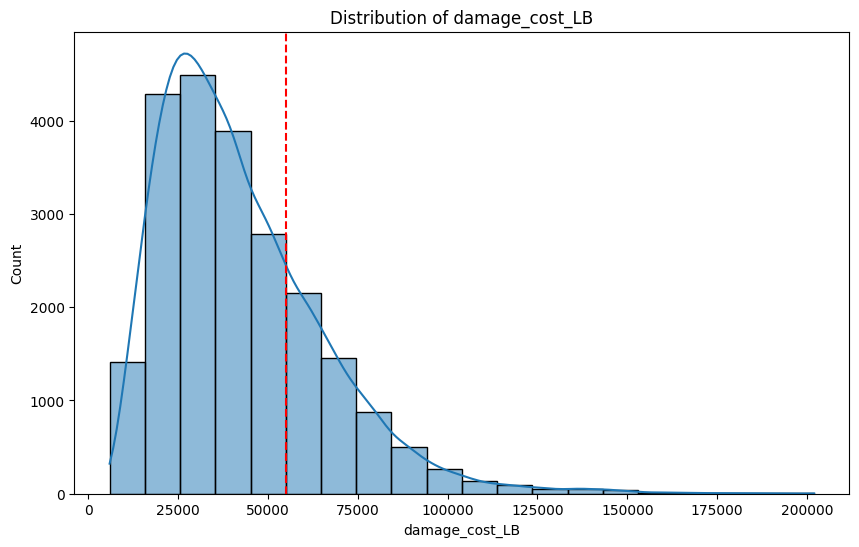

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df['damage_cost_LB'], bins=20, kde=True)
plt.axvline(df['damage_cost_LB'].quantile(0.75), color='red', linestyle='--')
plt.title('Distribution of damage_cost_LB')
plt.show()

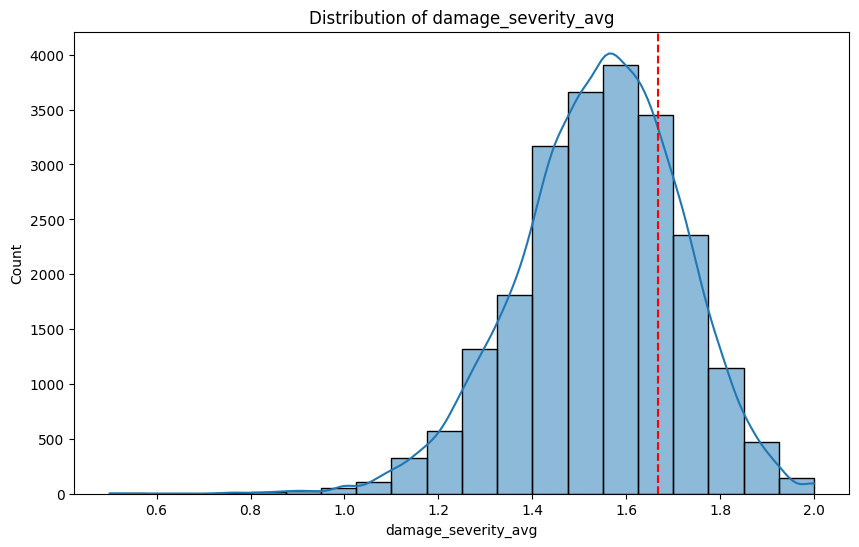

In [9]:
# distribution of damage_severity_avg
plt.figure(figsize=(10, 6))
sns.histplot(df['damage_severity_avg'], bins=20, kde=True)
plt.axvline(df['damage_severity_avg'].quantile(0.75), color='red', linestyle='--')
plt.title('Distribution of damage_severity_avg')
plt.show()


---

## Target variable definition
we will use the 75% quantile as the threshold for the damage_cost_LB, if the value is above this threshold we will consider it as a high damage and the Y value will be 1, otherwise 0


In [10]:
# first analisys using the damage_cost_LB column
df['DAMAGE_HIGH'] = df['damage_cost_LB'] > df['damage_cost_LB'].quantile(0.75)
df['DAMAGE_HIGH'] = df['DAMAGE_HIGH'].astype(int)



In [11]:
# DAMAGE columns
damage_columns = ['damage_cost_LB', 'damage_severity_avg']
df.drop(columns=damage_columns, inplace=True)
df.drop(columns=['BEAT_OF_OCCURRENCE'], inplace=True)

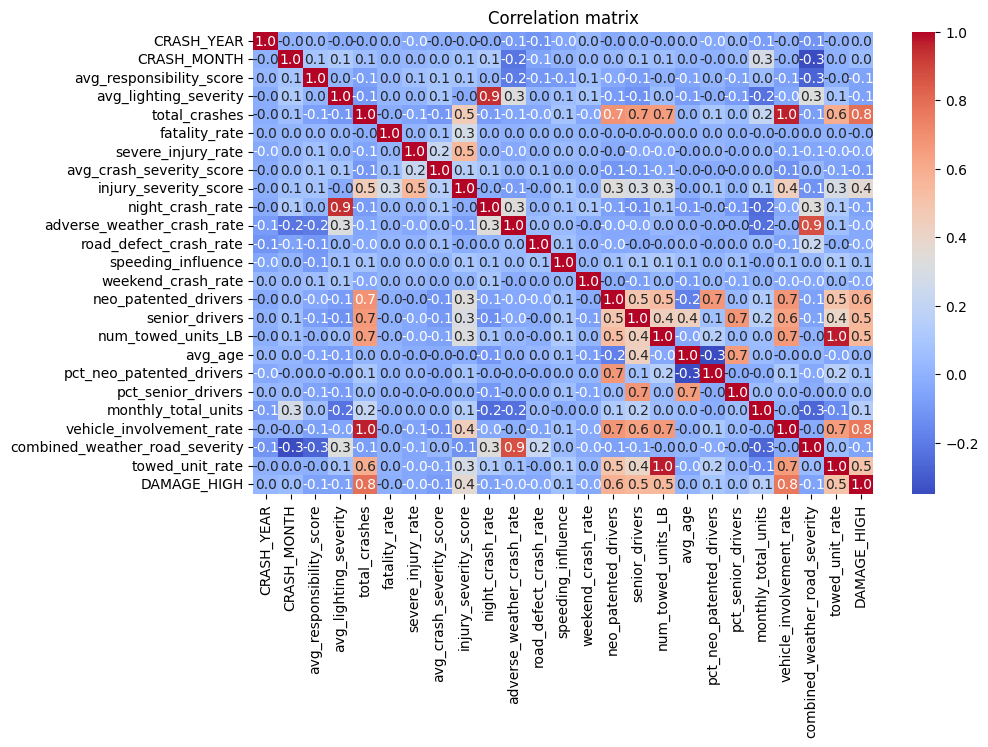

In [12]:
# correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Correlation matrix')
plt.show()


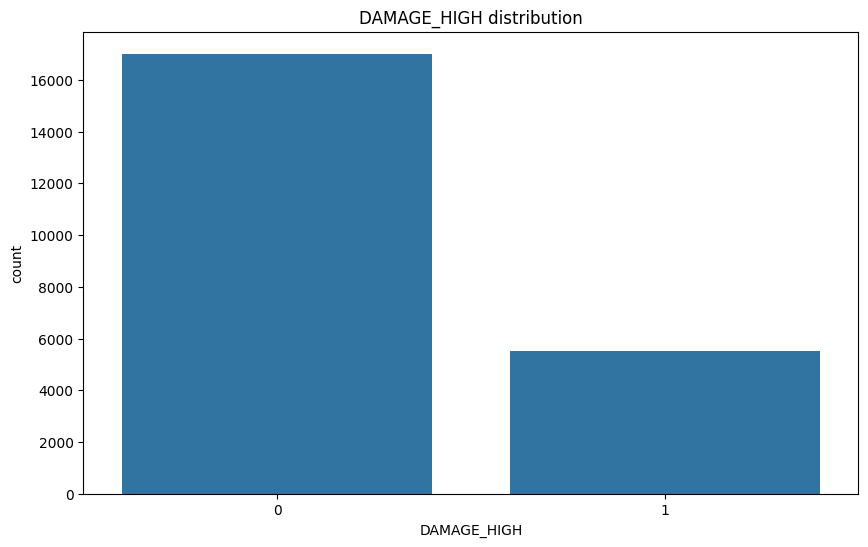

In [13]:
# plot DAMAGE_HIGH distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='DAMAGE_HIGH')
plt.title('DAMAGE_HIGH distribution')
plt.show()


In [14]:
df_train = df[df['CRASH_YEAR'] != 2024]
df_test = df[df['CRASH_YEAR'] == 2024]

In [15]:
len(df_train), len(df_test)

(19289, 3227)

In [16]:
len(df_test) / len(df_train) * 100

16.729742340193894

## X and Y features

In [17]:
X_train = df_train.drop(columns=['DAMAGE_HIGH'])
y_train = df_train['DAMAGE_HIGH']

X_test = df_test.drop(columns=['DAMAGE_HIGH'])
y_test = df_test['DAMAGE_HIGH']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19289, 24), (19289,), (3227, 24), (3227,))

---

# Models

The models that we will be using will be:
- Decision Trees
- Knn
- Naive Bayes
- Random Forests
- XGBoost
- Ada Boost
- Neural Network

## Random Forest

In [18]:
np.random.seed(42)
sklearn_random_seed = 42

In [19]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

hp_dt = {
    'max_depth': [3, 5, 7, 9, 11],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'criterion': ['gini', 'entropy'],
}

from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier(random_state=sklearn_random_seed)

grid_dt = GridSearchCV(estimator=dt, param_grid=hp_dt, cv=5, n_jobs=-1, verbose=1)
grid_dt.fit(X_train, y_train)

grid_dt.best_params_


Fitting 5 folds for each of 250 candidates, totalling 1250 fits


c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 4}

In [20]:
print(f"Train accuracy: {grid_dt.best_score_:.2f}")
print(f"Test accuracy: {grid_dt.score(X_test, y_test):.2f}")
print(classification_report(y_test, grid_dt.predict(X_test)))
confusion_matrix(y_test, grid_dt.predict(X_test))



Train accuracy: 0.97
Test accuracy: 0.98
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2316
           1       0.95      0.97      0.96       911

    accuracy                           0.98      3227
   macro avg       0.97      0.97      0.97      3227
weighted avg       0.98      0.98      0.98      3227



array([[2274,   42],
       [  30,  881]])

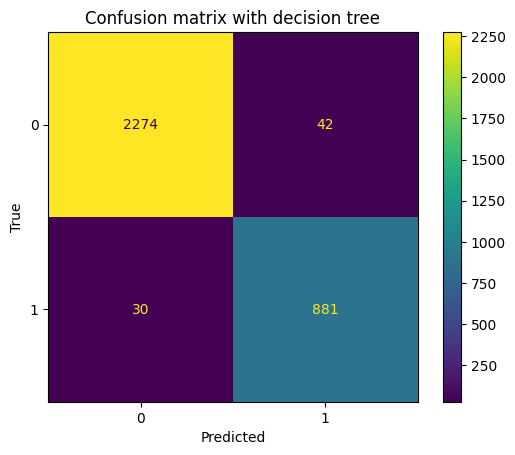

In [21]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sns

cm = confusion_matrix(y_test, grid_dt.predict(X_test))
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_dt.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with decision tree')
plt.show()

---

## KNN

In [22]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


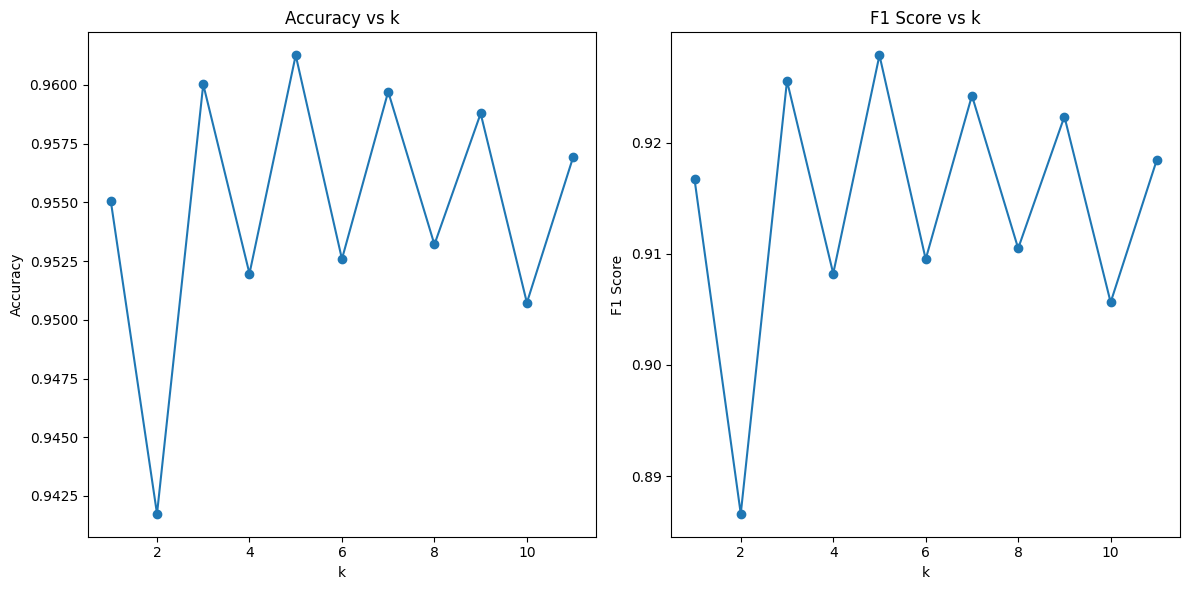

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# List of k values to try
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# Lists to store the results
accuracies = []
f1_scores = []

for k in tqdm(k_values):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree', metric='minkowski')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    # Store the results
    accuracies.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k')

plt.subplot(1, 2, 2)
plt.plot(k_values, f1_scores, marker='o')
plt.xlabel('k')
plt.ylabel('F1 Score')
plt.title('F1 Score vs k')

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2316
           1       0.99      0.87      0.92       911

    accuracy                           0.96      3227
   macro avg       0.97      0.93      0.95      3227
weighted avg       0.96      0.96      0.96      3227



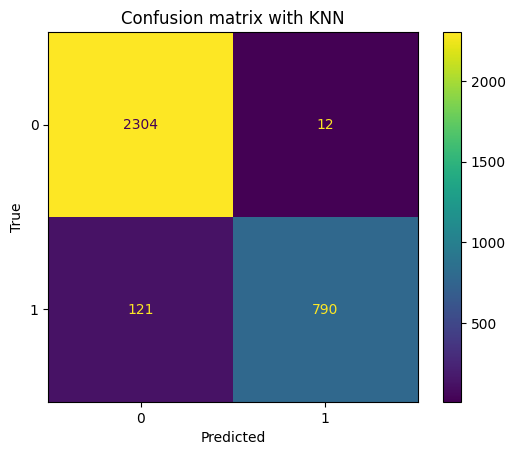

In [24]:
# confusion matrix with best k
knn = KNeighborsClassifier(n_neighbors=9, algorithm='ball_tree', metric='minkowski')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
cm_knn = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=knn.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with KNN')
plt.show()

---

## Random Forest

In [25]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

hp_rf = {
    'n_estimators': [8, 16, 32, 64],
    'max_depth': [3, 7, 11],
    'min_samples_split': [4, 8, 16],
    'min_samples_leaf': [2, 4],
    'criterion': ['gini', 'entropy'],
}

rf = RandomForestClassifier(random_state=sklearn_random_seed)

grid_rf = GridSearchCV(estimator=rf, param_grid=hp_rf, cv=5, n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

grid_rf.best_params_




Fitting 5 folds for each of 144 candidates, totalling 720 fits


{'criterion': 'entropy',
 'max_depth': 11,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 64}

In [26]:
print(f"Train accuracy: {grid_rf.best_score_:.2f}")
print(f"Test accuracy: {grid_rf.score(X_test, y_test):.2f}")
print(classification_report(y_test, grid_rf.predict(X_test)))
confusion_matrix(y_test, grid_rf.predict(X_test))

Train accuracy: 0.97
Test accuracy: 0.97
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2316
           1       0.98      0.91      0.94       911

    accuracy                           0.97      3227
   macro avg       0.97      0.95      0.96      3227
weighted avg       0.97      0.97      0.97      3227



array([[2298,   18],
       [  79,  832]])

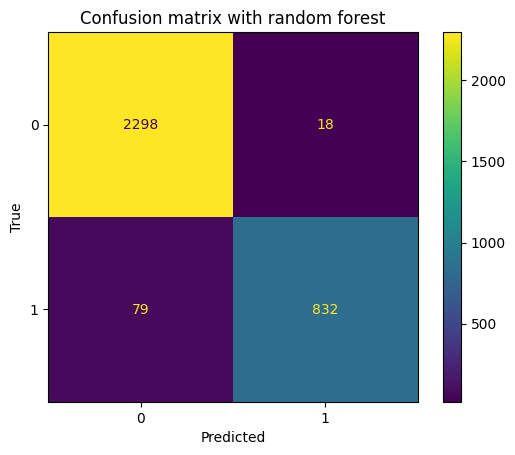

In [27]:
# confusion matrix
cm_rf = confusion_matrix(y_test, grid_rf.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=grid_rf.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Confusion matrix with random forest')
plt.show()

---

## feature analisys with SHAP

In [28]:
import shap

explainer = shap.TreeExplainer(model=grid_dt.best_estimator_)

In [29]:
shap_values = explainer.shap_values(X_test)

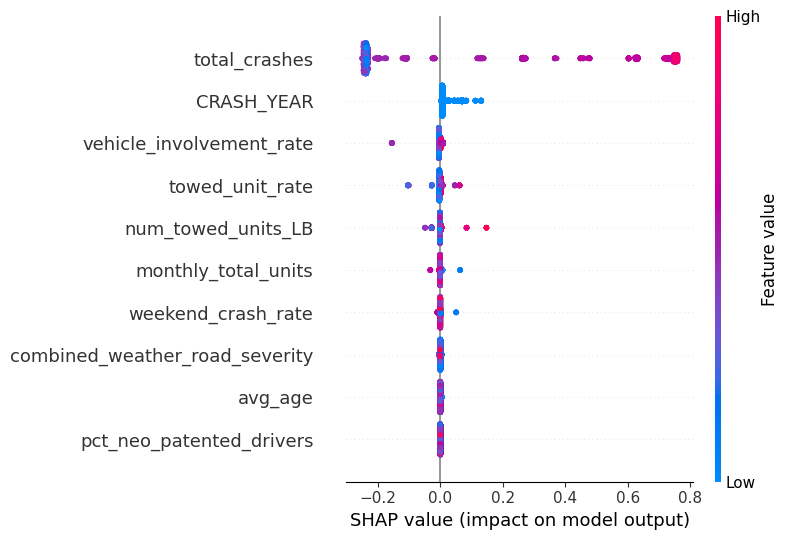

In [30]:
# Extract SHAP values for class 1
shap_values_class_1 = shap_values[:, :, 1]
shap_values_class_0 = shap_values[:, :, 0]

shap.summary_plot(shap_values_class_1, X_test, max_display=10)

we can clearly see how the prediction is based mainly on the total_crashes column which we saw it was highly correlated to the damage feature.

In [31]:
df.columns

Index(['CRASH_YEAR', 'CRASH_MONTH', 'avg_responsibility_score',
       'avg_lighting_severity', 'total_crashes', 'fatality_rate',
       'severe_injury_rate', 'avg_crash_severity_score',
       'injury_severity_score', 'night_crash_rate',
       'adverse_weather_crash_rate', 'road_defect_crash_rate',
       'speeding_influence', 'weekend_crash_rate', 'neo_patented_drivers',
       'senior_drivers', 'num_towed_units_LB', 'avg_age',
       'pct_neo_patented_drivers', 'pct_senior_drivers', 'monthly_total_units',
       'vehicle_involvement_rate', 'combined_weather_road_severity',
       'towed_unit_rate', 'DAMAGE_HIGH'],
      dtype='object')

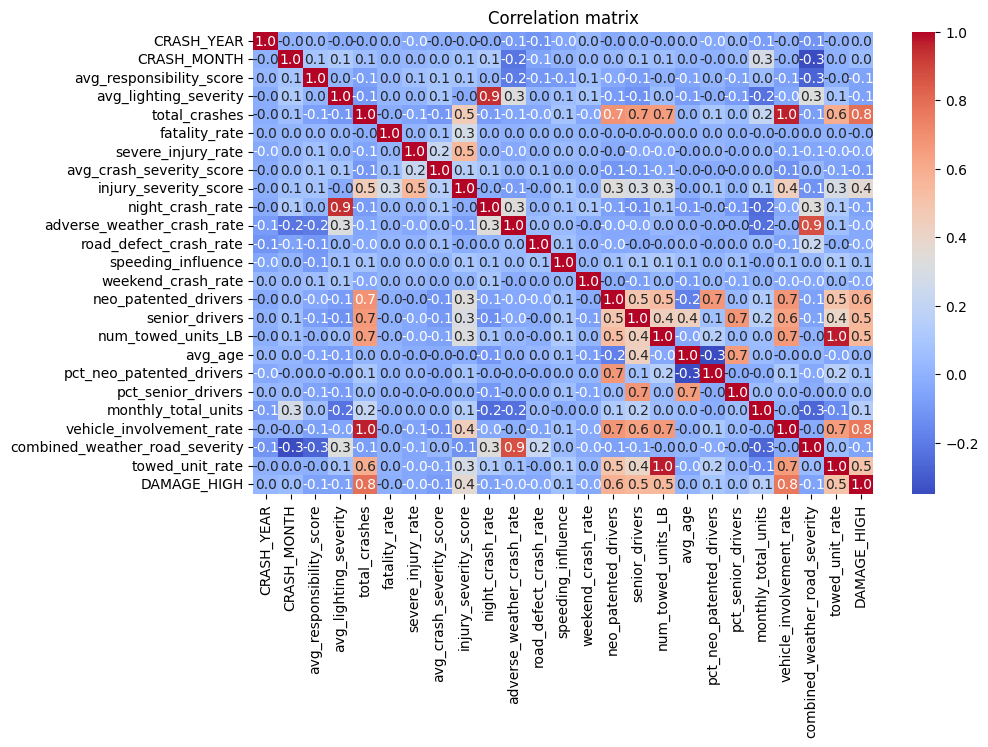

In [32]:
# correlation matrix
plt.figure(figsize=(10, 6))

sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Correlation matrix')
plt.show()


In [33]:
columns_highly_correlated = ['total_crashes', 'vehicle_involvement_rate']
df.drop(columns=columns_highly_correlated, inplace=True)

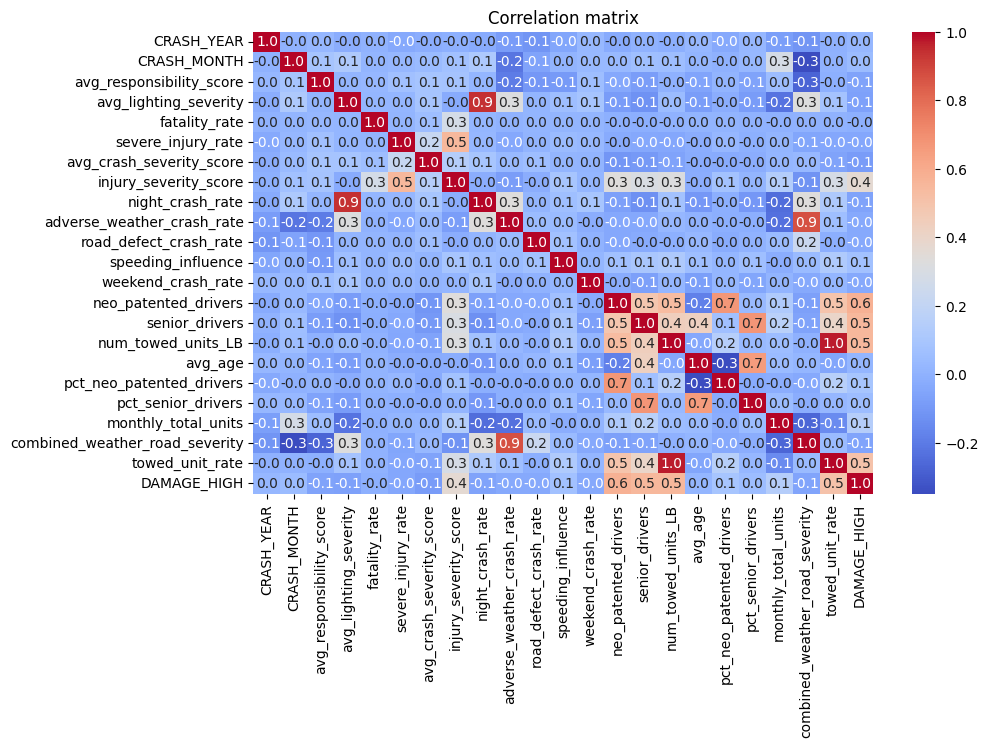

In [34]:
# correlation matrix
plt.figure(figsize=(10, 6))

sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Correlation matrix')
plt.show()


In [35]:
# train test split
df_train = df[df['CRASH_YEAR'] != 2024]
df_test = df[df['CRASH_YEAR'] == 2024]

X_train = df_train.drop(columns=['DAMAGE_HIGH'])
y_train = df_train['DAMAGE_HIGH']

X_test = df_test.drop(columns=['DAMAGE_HIGH'])
y_test = df_test['DAMAGE_HIGH']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19289, 22), (19289,), (3227, 22), (3227,))

---

## Decision Tree without highly correlated features

In [36]:
# decision tree
dt = DecisionTreeClassifier(random_state=sklearn_random_seed)

grid_dt = GridSearchCV(estimator=dt, param_grid=hp_dt, cv=5, n_jobs=-1, verbose=1)
grid_dt.fit(X_train, y_train)

grid_dt.best_params_

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


{'criterion': 'gini',
 'max_depth': 11,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

In [37]:
print(f"Train accuracy: {grid_dt.best_score_:.2f}")
print(f"Test accuracy: {grid_dt.score(X_test, y_test):.2f}")

print(classification_report(y_test, grid_dt.predict(X_test)))
confusion_matrix(y_test, grid_dt.predict(X_test))


Train accuracy: 0.95
Test accuracy: 0.94
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2316
           1       0.95      0.84      0.89       911

    accuracy                           0.94      3227
   macro avg       0.94      0.91      0.93      3227
weighted avg       0.94      0.94      0.94      3227



array([[2273,   43],
       [ 143,  768]])

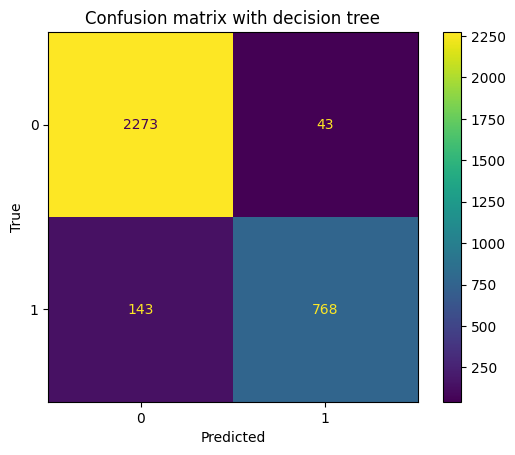

In [38]:
# confusion matrix
cm = confusion_matrix(y_test, grid_dt.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_dt.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with decision tree')

plt.show()


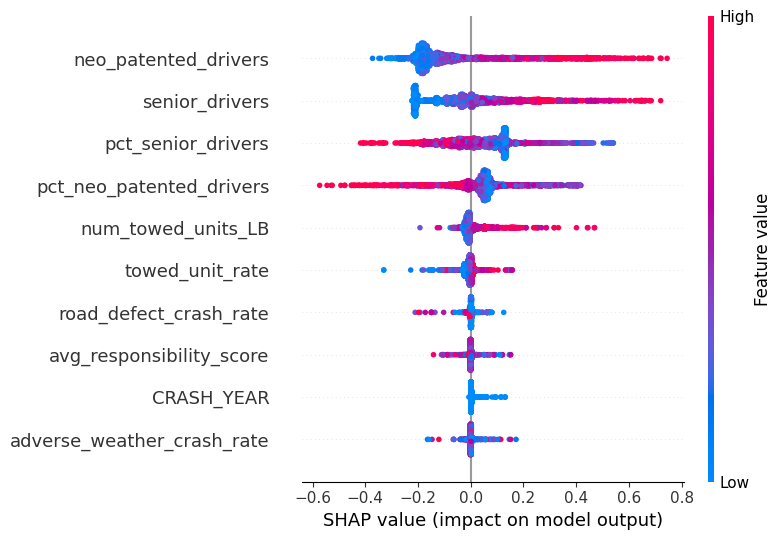

In [39]:
# shap values
explainer = shap.TreeExplainer(model=grid_dt.best_estimator_)
shap_values = explainer.shap_values(X_test)

# Extract SHAP values for class 1
shap_values_class_1 = shap_values[:, :, 1]

shap.summary_plot(shap_values_class_1, X_test, max_display=10)


---

## More feature removal

Let's try to remove all the feature that capture the number of event, such as number of drivers of a specific age or number of towed vehicles, which could capture the magnitude of the number of crashes happened a given month for a department which, as we saw, is highly correlated to the total damage.

In [40]:
df.columns

Index(['CRASH_YEAR', 'CRASH_MONTH', 'avg_responsibility_score',
       'avg_lighting_severity', 'fatality_rate', 'severe_injury_rate',
       'avg_crash_severity_score', 'injury_severity_score', 'night_crash_rate',
       'adverse_weather_crash_rate', 'road_defect_crash_rate',
       'speeding_influence', 'weekend_crash_rate', 'neo_patented_drivers',
       'senior_drivers', 'num_towed_units_LB', 'avg_age',
       'pct_neo_patented_drivers', 'pct_senior_drivers', 'monthly_total_units',
       'combined_weather_road_severity', 'towed_unit_rate', 'DAMAGE_HIGH'],
      dtype='object')

In [41]:
columns_with_count = ['neo_patented_drivers', 'senior_drivers', 'num_towed_units_LB']

In [42]:
df = df.drop(columns=columns_with_count)

In [43]:
df_train = df[df['CRASH_YEAR'] != 2024]
df_test = df[df['CRASH_YEAR'] == 2024]

X_train = df_train.drop(columns=['DAMAGE_HIGH'])
y_train = df_train['DAMAGE_HIGH']

X_test = df_test.drop(columns=['DAMAGE_HIGH'])
y_test = df_test['DAMAGE_HIGH']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19289, 19), (19289,), (3227, 19), (3227,))

In [44]:
# save the dataset to a new csv file
df.to_csv('dataset/incident_profile_nn.csv', index=False)


---

### Decision Tree without flat numbers

In [45]:
dt = DecisionTreeClassifier(random_state=sklearn_random_seed)

grid_dt = GridSearchCV(estimator=dt, param_grid=hp_dt, cv=5, n_jobs=-1, verbose=1)
grid_dt.fit(X_train, y_train)

grid_dt.best_params_


Fitting 5 folds for each of 250 candidates, totalling 1250 fits


{'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

In [46]:
print(f"Train accuracy: {grid_dt.best_score_:.2f}")
print(f"Test accuracy: {grid_dt.score(X_test, y_test):.2f}")
print(classification_report(y_test, grid_dt.predict(X_test)))
confusion_matrix(y_test, grid_dt.predict(X_test))

Train accuracy: 0.86
Test accuracy: 0.85
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      2316
           1       0.80      0.62      0.70       911

    accuracy                           0.85      3227
   macro avg       0.83      0.78      0.80      3227
weighted avg       0.84      0.85      0.84      3227



array([[2174,  142],
       [ 349,  562]])

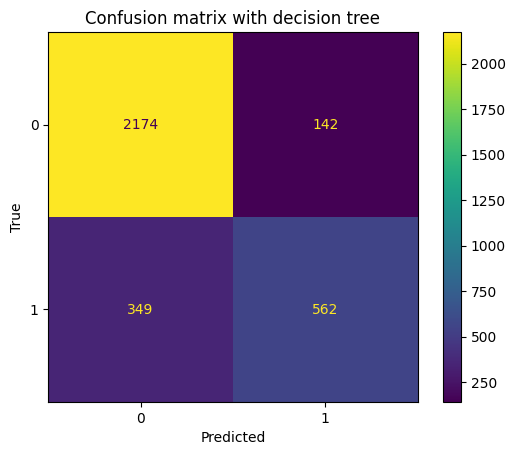

In [47]:
# confusion matrix
cm = confusion_matrix(y_test, grid_dt.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_dt.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with decision tree')

plt.show()

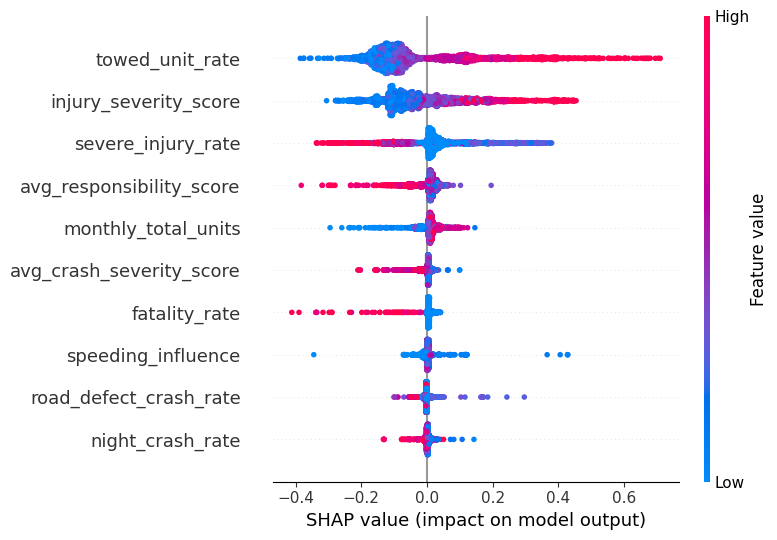

In [48]:
# shap values
explainer = shap.TreeExplainer(model=grid_dt.best_estimator_)
shap_values = explainer.shap_values(X_test)

# Extract SHAP values for class 1
shap_values_class_1 = shap_values[:, :, 1]

shap.summary_plot(shap_values_class_1, X_test, max_display=10)


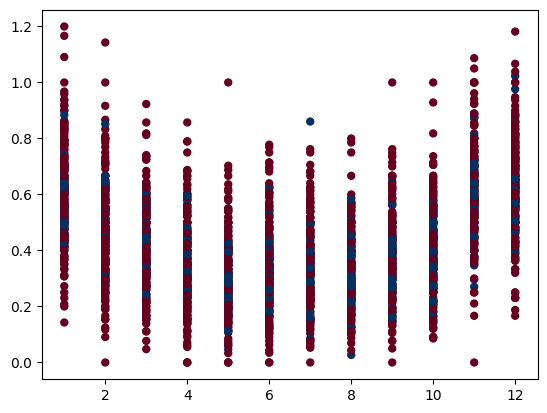

In [49]:
test_set = X_test.copy()
test_label = y_test.copy()

from sklearn.datasets import make_blobs
plt.scatter(test_set.iloc[:, 1].values, test_set.iloc[:, 3].values, c=test_label.values, s=25, cmap='RdBu');

---

### Knn

100%|██████████| 11/11 [00:03<00:00,  3.37it/s]


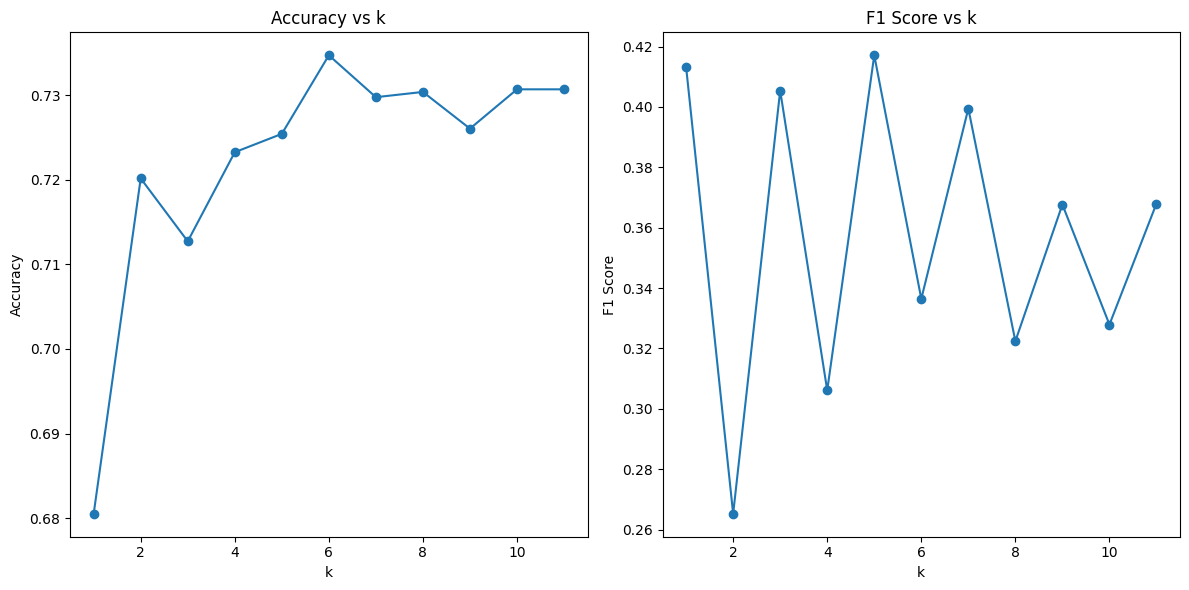

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# List of k values to try
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# Lists to store the results
accuracies = []
f1_scores = []

for k in tqdm(k_values):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree', metric='minkowski')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    # Store the results
    accuracies.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k')

plt.subplot(1, 2, 2)
plt.plot(k_values, f1_scores, marker='o')
plt.xlabel('k')
plt.ylabel('F1 Score')
plt.title('F1 Score vs k')

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.77      0.87      0.82      2316
           1       0.52      0.35      0.42       911

    accuracy                           0.73      3227
   macro avg       0.65      0.61      0.62      3227
weighted avg       0.70      0.73      0.71      3227



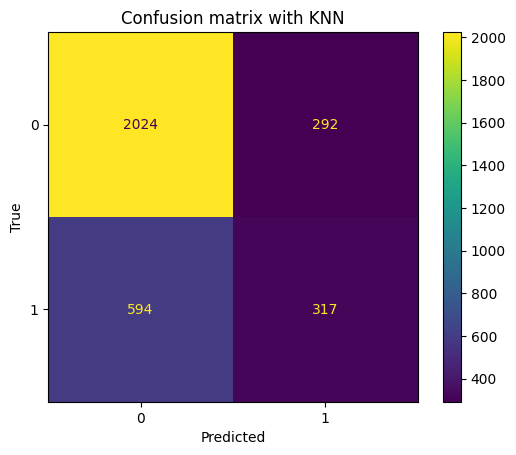

In [51]:
# confusion matrix with best k
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='minkowski')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
cm_knn = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=knn.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with KNN')
plt.show()

---

### Random Forest

In [52]:
# Random Forest

rf = RandomForestClassifier(random_state=sklearn_random_seed)

grid_rf = GridSearchCV(estimator=rf, param_grid=hp_rf, cv=5, n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

grid_rf.best_params_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'criterion': 'gini',
 'max_depth': 11,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 64}

In [53]:
print(f"Train accuracy: {grid_rf.best_score_:.2f}")
print(f"Test accuracy: {grid_rf.score(X_test, y_test):.2f}")
print(classification_report(y_test, grid_rf.predict(X_test)))
confusion_matrix(y_test, grid_rf.predict(X_test))


Train accuracy: 0.89
Test accuracy: 0.87
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      2316
           1       0.91      0.60      0.73       911

    accuracy                           0.87      3227
   macro avg       0.89      0.79      0.82      3227
weighted avg       0.88      0.87      0.86      3227



array([[2263,   53],
       [ 360,  551]])

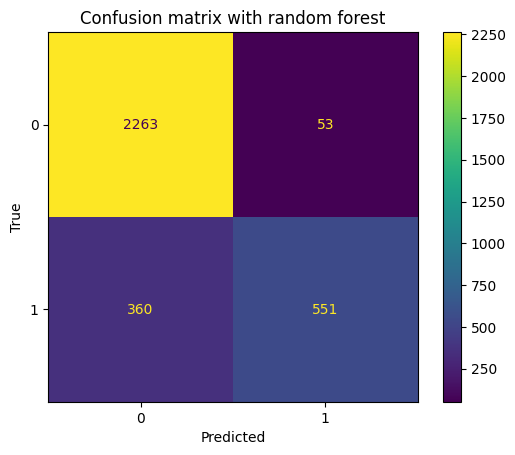

In [54]:
# confusion matrix
cm_rf = confusion_matrix(y_test, grid_rf.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=grid_rf.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with random forest')

plt.show()


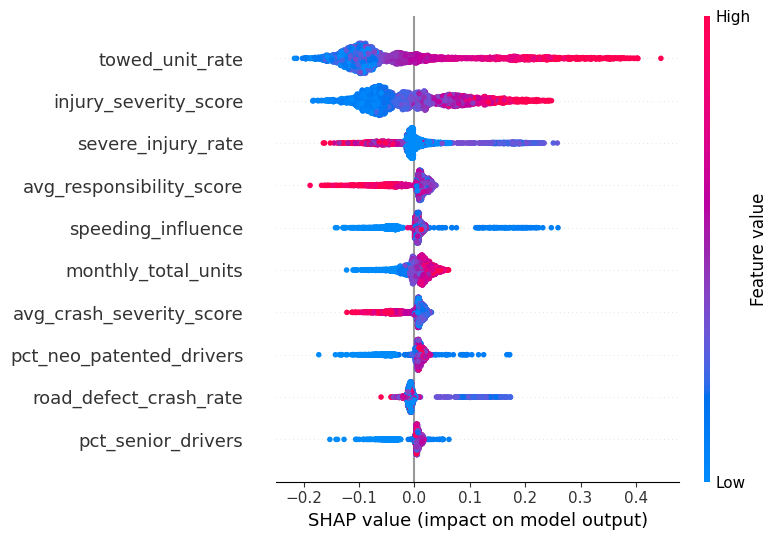

In [55]:
# shape values for random forest
explainer = shap.TreeExplainer(model=grid_rf.best_estimator_)
shap_values = explainer.shap_values(X_test)

# Extract SHAP values for class 1
shap_values_class_1 = shap_values[:, :, 1]

shap.summary_plot(shap_values_class_1, X_test, max_display=10)


---

### Naive Bayes


Train accuracy: 0.77
Test accuracy: 0.73
              precision    recall  f1-score   support

           0       0.84      0.77      0.81      2316
           1       0.52      0.63      0.57       911

    accuracy                           0.73      3227
   macro avg       0.68      0.70      0.69      3227
weighted avg       0.75      0.73      0.74      3227



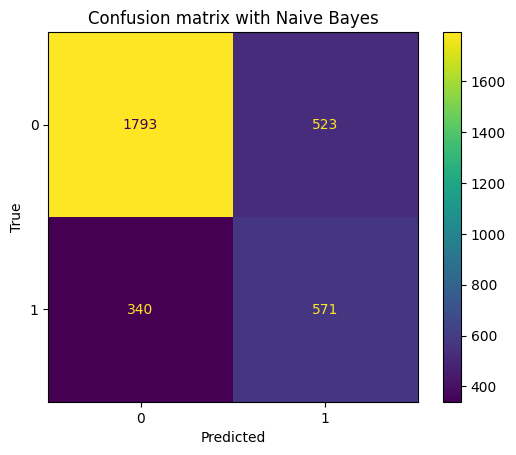

In [56]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

print(f"Train accuracy: {nb.score(X_train, y_train):.2f}")
print(f"Test accuracy: {nb.score(X_test, y_test):.2f}")
print(classification_report(y_test, nb.predict(X_test)))

# confusion matrix
cm_nb = confusion_matrix(y_test, nb.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=nb.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with Naive Bayes')

plt.show()

---

### XGBoost

In [57]:
from xgboost import XGBClassifier


base_model = XGBClassifier()
hyperparameters_xg = {
    "n_estimators": [25, 100, 250],
    "max_depth": [2, 4, 8],
    "learning_rate": [0.1, 0.001, 0.0001]
}
search = GridSearchCV(base_model, hyperparameters_xg, cv=5, n_jobs=-1, verbose=1)
search.fit(X_train, y_train)
xg_boost = search.best_estimator_
xg_boost.fit(X_train, y_train)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [58]:
print(f"Train accuracy: {xg_boost.score(X_train, y_train):.2f}")
print(f"Test accuracy: {xg_boost.score(X_test, y_test):.2f}")
print(classification_report(y_test, xg_boost.predict(X_test)))
confusion_matrix(y_test, xg_boost.predict(X_test))


Train accuracy: 0.92
Test accuracy: 0.90
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2316
           1       0.93      0.71      0.81       911

    accuracy                           0.90      3227
   macro avg       0.91      0.84      0.87      3227
weighted avg       0.91      0.90      0.90      3227



array([[2268,   48],
       [ 264,  647]])

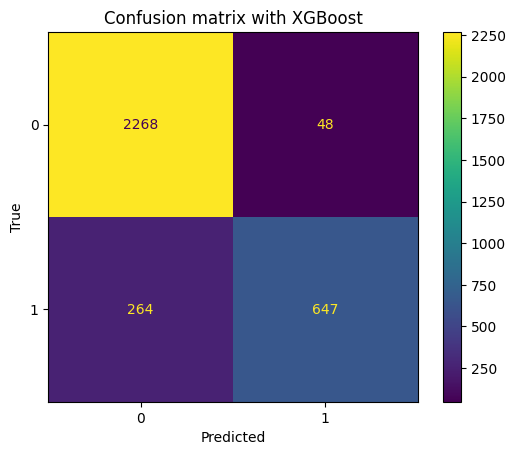

In [59]:
# confusion matrix
cm_xg = confusion_matrix(y_test, xg_boost.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xg, display_labels=xg_boost.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with XGBoost')

plt.show()

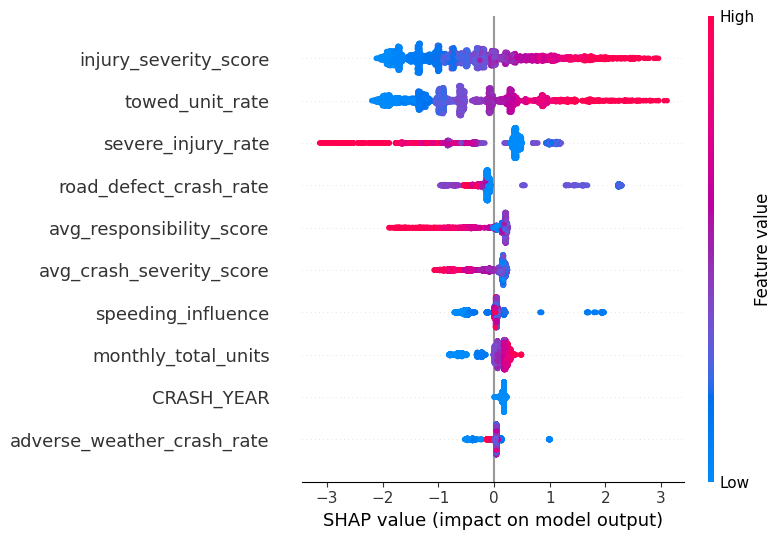

In [60]:
# shap values
explainer = shap.TreeExplainer(model=xg_boost)
shap_values = explainer.shap_values(X_test)

# Extract SHAP values for all classes
shap_values_all_classes = shap_values

shap.summary_plot(shap_values_all_classes, X_test, max_display=10)



---

### ADA Boost

In [61]:
# ADA Boost
from sklearn.ensemble import AdaBoostClassifier

base_model = AdaBoostClassifier()
hyperparameters_ada = {
    "n_estimators": [25, 100, 250],
    "learning_rate": [0.1, 0.001, 0.0001]
}
search = GridSearchCV(base_model, hyperparameters_ada, cv=5, n_jobs=-1, verbose=1)
search.fit(X_train, y_train)
ada_boost = search.best_estimator_
ada_boost.fit(X_train, y_train)



Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(learning_rate=0.1, n_estimators=250)

In [62]:
print(f"Train accuracy: {ada_boost.score(X_train, y_train):.2f}")
print(f"Test accuracy: {ada_boost.score(X_test, y_test):.2f}")
print(classification_report(y_test, ada_boost.predict(X_test)))
confusion_matrix(y_test, ada_boost.predict(X_test))

Train accuracy: 0.90
Test accuracy: 0.86
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      2316
           1       0.92      0.57      0.70       911

    accuracy                           0.86      3227
   macro avg       0.89      0.78      0.81      3227
weighted avg       0.87      0.86      0.85      3227



array([[2272,   44],
       [ 392,  519]])

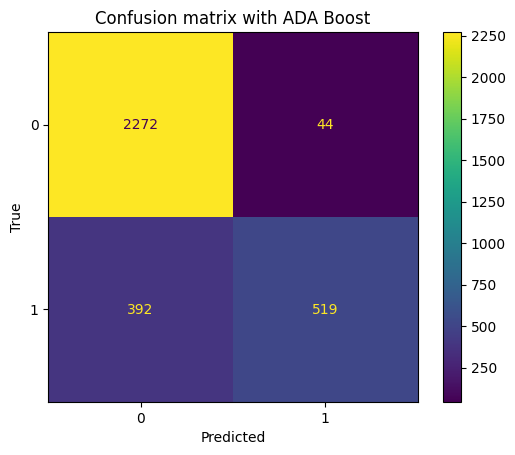

In [63]:
# confusion matrix
cm_ada = confusion_matrix(y_test, ada_boost.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ada, display_labels=ada_boost.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with ADA Boost')

plt.show()

---

## Neural Network

In [64]:
import pandas as pd

# load the dataset
df = pd.read_csv('dataset/incident_profile_nn.csv')


In [65]:
# train test split
df_train = df[df['CRASH_YEAR'] != 2024]
df_test = df[df['CRASH_YEAR'] == 2024]

X_train = df_train.drop(columns=['DAMAGE_HIGH'])
y_train = df_train['DAMAGE_HIGH']

X_test = df_test.drop(columns=['DAMAGE_HIGH'])
y_test = df_test['DAMAGE_HIGH']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19289, 19), (19289,), (3227, 19), (3227,))

In [66]:
# scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [67]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19289 entries, 0 to 19288
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CRASH_YEAR                      19289 non-null  int64  
 1   CRASH_MONTH                     19289 non-null  int64  
 2   avg_responsibility_score        19289 non-null  float64
 3   avg_lighting_severity           19289 non-null  float64
 4   fatality_rate                   19289 non-null  float64
 5   severe_injury_rate              19289 non-null  float64
 6   avg_crash_severity_score        19289 non-null  float64
 7   injury_severity_score           19289 non-null  float64
 8   night_crash_rate                19289 non-null  float64
 9   adverse_weather_crash_rate      19289 non-null  float64
 10  road_defect_crash_rate          19289 non-null  float64
 11  speeding_influence              19289 non-null  float64
 12  weekend_crash_rate              19289

In [68]:
from sklearn.model_selection import train_test_split

X_train_full = X_train_scaled.copy()
y_train_full = y_train.copy()

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [69]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold
import tensorflow as tf

def create_model(optimizer='adam', neurons1=128, neurons2=32):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(19,)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(neurons1, activation='relu'),
    tf.keras.layers.Dense(neurons2, activation='relu'),  # Second layer
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer=optimizer,
          loss='binary_crossentropy',
          metrics=['accuracy'])
  return model


In [70]:
# Wrap the model
model = KerasClassifier(build_fn=create_model, verbose=0, neurons1=128, neurons2=32)


In [71]:
# k-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

hyperparameters_nn = {
  'optimizer': ['adam'],
  'neurons1' : [64, 128],
  'neurons2' : [16, 32, 64],
  'batch_size': [32],
  'epochs': [20]
}

# grid search
grid_search_nn = GridSearchCV(estimator=model, param_grid=hyperparameters_nn, cv=kf, scoring='f1', n_jobs=-1, verbose=3)


In [72]:
grid_search_nn.fit(X_train, y_train, validation_data=(X_val, y_val))


Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KerasClassifier(build_fn=<function create_model at 0x000001E605ED93F0>, neurons1=128, neurons2=32, verbose=0),
             n_jobs=-1,
             param_grid={'batch_size': [32], 'epochs': [20],
                         'neurons1': [64, 128], 'neurons2': [16, 32, 64],
                         'optimizer': ['adam']},
             scoring='f1', verbose=3)

In [73]:
# Print the best parameters and the best score
print(f"Best parameters: {grid_search_nn.best_params_}")
print(f"Best score: {grid_search_nn.best_score_}")

# Save the training and validation accuracy for the best model
history = grid_search_nn.best_estimator_.model_.history
training_acc = history.history.get('accuracy', [])
validation_acc = history.history.get('val_accuracy', [])

Best parameters: {'batch_size': 32, 'epochs': 20, 'neurons1': 128, 'neurons2': 16, 'optimizer': 'adam'}
Best score: 0.750743747007655


              precision    recall  f1-score   support

           0       0.89      0.93      0.91      2316
           1       0.79      0.70      0.74       911

    accuracy                           0.86      3227
   macro avg       0.84      0.81      0.82      3227
weighted avg       0.86      0.86      0.86      3227



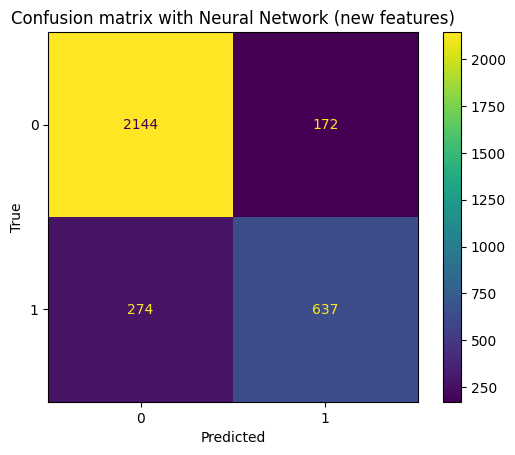

In [74]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# evaluation of the best model
best_model = grid_search_nn.best_estimator_
y_pred = best_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# confusion matrix
cm_nn = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=[0, 1])
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with Neural Network (new features)')
plt.show()

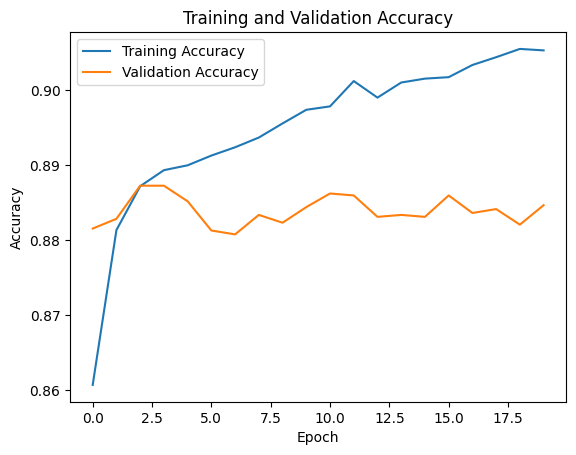

In [75]:
#plot
plt.plot(training_acc, label='Training Accuracy')
plt.plot(validation_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

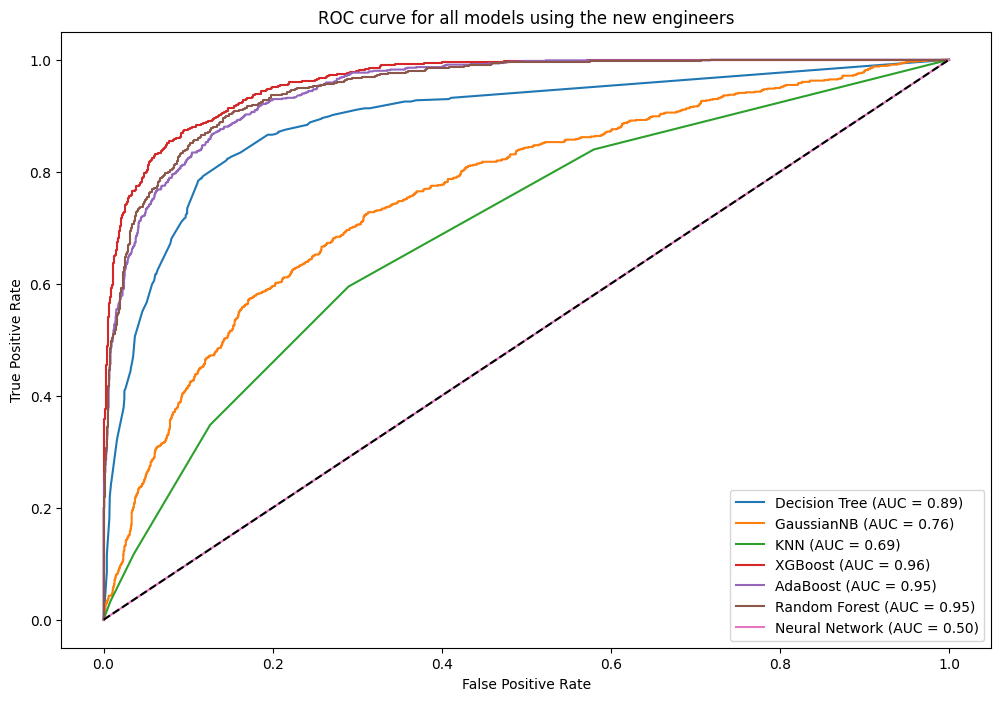

In [76]:
# ROC curve for all the models

from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
plt.figure(figsize=(12, 8))

# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, grid_dt.predict_proba(X_test)[:, 1])
roc_auc_dt = roc_auc_score(y_test, grid_dt.predict_proba(X_test)[:, 1])
plt.plot(fpr_dt, tpr_dt, label='Decision Tree (AUC = %0.2f)' % roc_auc_dt)

# GaussianNB
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, nb.predict_proba(X_test)[:, 1])
roc_auc_gnb = roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1])
plt.plot(fpr_gnb, tpr_gnb, label='GaussianNB (AUC = %0.2f)' % roc_auc_gnb)

# KNN
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn.predict_proba(X_test)[:, 1])
roc_auc_knn = roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])
plt.plot(fpr_knn, tpr_knn, label='KNN (AUC = %0.2f)' % roc_auc_knn)

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xg_boost.predict_proba(X_test)[:, 1])
roc_auc_xgb = roc_auc_score(y_test, xg_boost.predict_proba(X_test)[:, 1])
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)

# AdaBoost
fpr_ada, tpr_ada, _ = roc_curve(y_test, ada_boost.predict_proba(X_test)[:, 1])
roc_auc_ada = roc_auc_score(y_test, ada_boost.predict_proba(X_test)[:, 1])
plt.plot(fpr_ada, tpr_ada, label='AdaBoost (AUC = %0.2f)' % roc_auc_ada)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, grid_rf.predict_proba(X_test)[:, 1])
roc_auc_rf = roc_auc_score(y_test, grid_rf.predict_proba(X_test)[:, 1])
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)

# Neural Network
fpr_nn, tpr_nn, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
roc_auc_nn = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
plt.plot(fpr_nn, tpr_nn, label='Neural Network (AUC = %0.2f)' % roc_auc_nn)

plt.plot([0, 1], [0, 1], 'k--')  # middle line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for all models using the new engineers')
plt.legend()

plt.show()

---

### NN with undersampling

In [77]:
## undersampling
df_under = pd.concat([df_train[df_train['DAMAGE_HIGH'] == 0].sample(n=df_train['DAMAGE_HIGH'].sum(), random_state=42), df_train[df_train['DAMAGE_HIGH'] == 1]])

df_under['DAMAGE_HIGH'].value_counts()

DAMAGE_HIGH
0    4595
1    4595
Name: count, dtype: int64

In [78]:
# split the data
X_train = df_under.drop(columns=['DAMAGE_HIGH'])
y_train = df_under['DAMAGE_HIGH']

X_train.shape, y_train.shape


((9190, 19), (9190,))

In [79]:

# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# get a validation set
X_train_full = X_train_scaled.copy()
y_train_full = y_train.copy()

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)



In [80]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((7352, 19), (7352,), (1838, 19), (1838,))

In [81]:
# nn with undersampling
grid_search_nn.fit(X_train, y_train, validation_data=(X_val, y_val))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KerasClassifier(build_fn=<function create_model at 0x000001E605ED93F0>, neurons1=128, neurons2=32, verbose=0),
             n_jobs=-1,
             param_grid={'batch_size': [32], 'epochs': [20],
                         'neurons1': [64, 128], 'neurons2': [16, 32, 64],
                         'optimizer': ['adam']},
             scoring='f1', verbose=3)

In [82]:

# Print the best parameters and the best score
print(f"Best parameters: {grid_search_nn.best_params_}")
print(f"Best score: {grid_search_nn.best_score_}")
# Save the training and validation accuracy for the best model
history_under = grid_search_nn.best_estimator_.model_.history
training_acc_under = history.history.get('accuracy', [])
validation_acc_under = history.history.get('val_accuracy', [])
# evaluation of the best model
best_model_under = grid_search_nn.best_estimator_



Best parameters: {'batch_size': 32, 'epochs': 20, 'neurons1': 64, 'neurons2': 32, 'optimizer': 'adam'}
Best score: 0.8595397866212153


              precision    recall  f1-score   support

           0       0.98      0.60      0.75      2316
           1       0.49      0.98      0.65       911

    accuracy                           0.71      3227
   macro avg       0.74      0.79      0.70      3227
weighted avg       0.85      0.71      0.72      3227



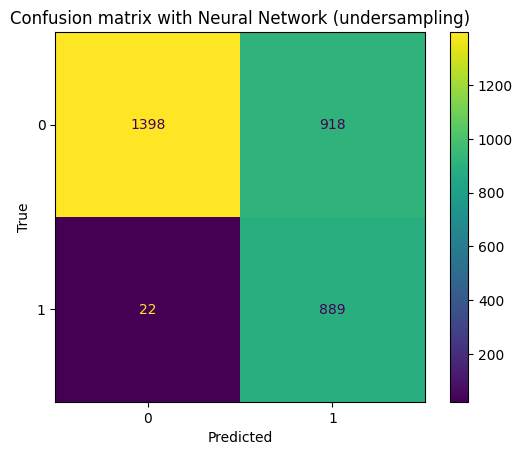

In [83]:
y_pred = best_model_under.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
# confusion matrix
cm_nn = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=[0, 1])
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with Neural Network (undersampling)')
plt.show()

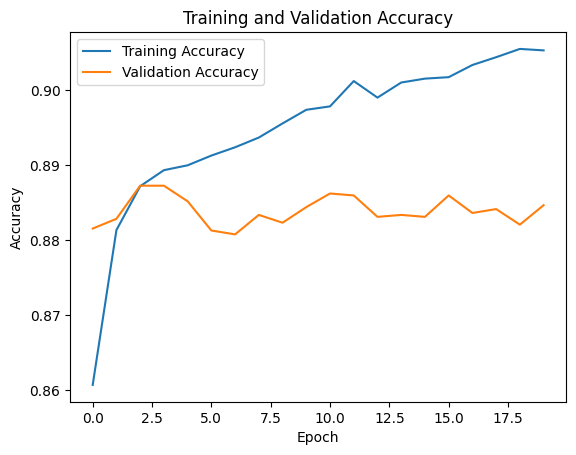

In [84]:
#plot
plt.plot(training_acc_under, label='Training Accuracy')
plt.plot(validation_acc_under, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.legend()

plt.show()

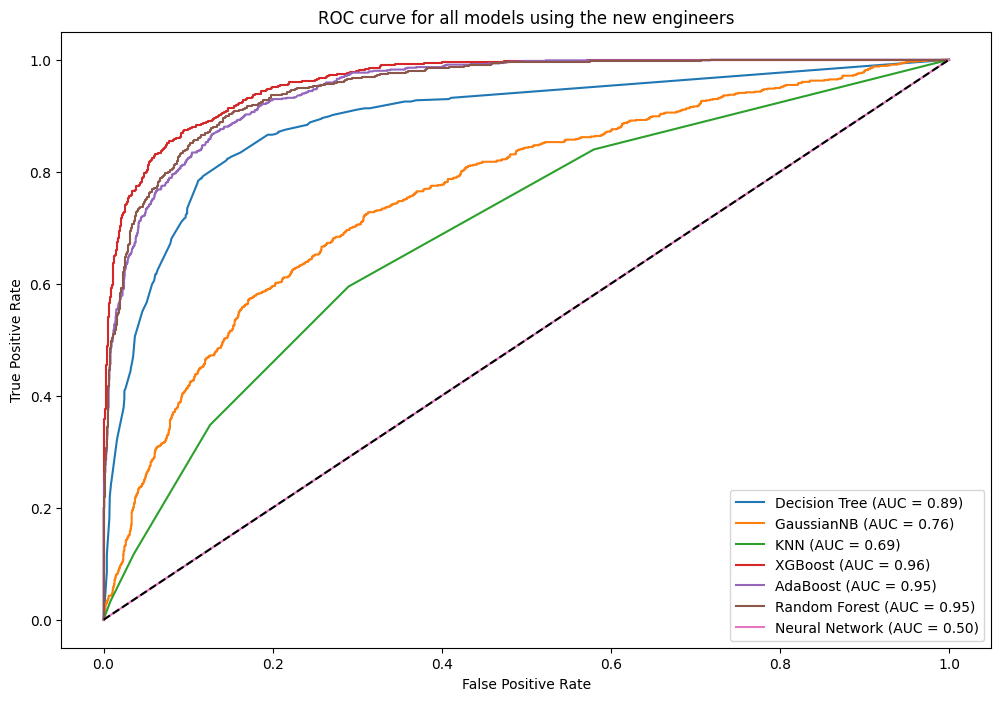

In [85]:
# ROC curve for all the models

from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
plt.figure(figsize=(12, 8))

# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, grid_dt.predict_proba(X_test)[:, 1])
roc_auc_dt = roc_auc_score(y_test, grid_dt.predict_proba(X_test)[:, 1])
plt.plot(fpr_dt, tpr_dt, label='Decision Tree (AUC = %0.2f)' % roc_auc_dt)

# GaussianNB
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, nb.predict_proba(X_test)[:, 1])
roc_auc_gnb = roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1])
plt.plot(fpr_gnb, tpr_gnb, label='GaussianNB (AUC = %0.2f)' % roc_auc_gnb)

# KNN
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn.predict_proba(X_test)[:, 1])
roc_auc_knn = roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])
plt.plot(fpr_knn, tpr_knn, label='KNN (AUC = %0.2f)' % roc_auc_knn)

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xg_boost.predict_proba(X_test)[:, 1])
roc_auc_xgb = roc_auc_score(y_test, xg_boost.predict_proba(X_test)[:, 1])
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)

# AdaBoost
fpr_ada, tpr_ada, _ = roc_curve(y_test, ada_boost.predict_proba(X_test)[:, 1])
roc_auc_ada = roc_auc_score(y_test, ada_boost.predict_proba(X_test)[:, 1])
plt.plot(fpr_ada, tpr_ada, label='AdaBoost (AUC = %0.2f)' % roc_auc_ada)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, grid_rf.predict_proba(X_test)[:, 1])
roc_auc_rf = roc_auc_score(y_test, grid_rf.predict_proba(X_test)[:, 1])
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)

# Neural Network
fpr_nn, tpr_nn, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
roc_auc_nn = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
plt.plot(fpr_nn, tpr_nn, label='Neural Network (AUC = %0.2f)' % roc_auc_nn)

plt.plot([0, 1], [0, 1], 'k--')  # middle line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for all models using the new engineers')
plt.legend()

plt.show()

---

## NN with Tensor Flow

More test to showcase the impact of scaling the dataset

In [86]:
import pandas as pd

# load the dataset
df = pd.read_csv('dataset/incident_profile_nn.csv')


In [87]:
# train test split
df_train = df[df['CRASH_YEAR'] != 2024]
df_test = df[df['CRASH_YEAR'] == 2024]

X_train = df_train.drop(columns=['DAMAGE_HIGH'])
y_train = df_train['DAMAGE_HIGH']

X_test = df_test.drop(columns=['DAMAGE_HIGH'])
y_test = df_test['DAMAGE_HIGH']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19289, 19), (19289,), (3227, 19), (3227,))

In [88]:
import tensorflow as tf
import numpy as np
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=X_train.shape[1:]),
  tf.keras.layers.Dense(32, activation='sigmoid'),  
  tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adamax',
              loss='mean_squared_error',
              metrics=['accuracy'])

c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [89]:
history = model.fit(X_train, y_train,
                    epochs=80,
                    batch_size=512,
                    validation_split=0.2)

Epoch 1/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2267 - loss: 0.4030 - val_accuracy: 0.2680 - val_loss: 0.3142
Epoch 2/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2312 - loss: 0.3010 - val_accuracy: 0.7320 - val_loss: 0.2463
Epoch 3/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7650 - loss: 0.2342 - val_accuracy: 0.7320 - val_loss: 0.2147
Epoch 4/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7737 - loss: 0.2016 - val_accuracy: 0.7320 - val_loss: 0.2026
Epoch 5/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7724 - loss: 0.1882 - val_accuracy: 0.7320 - val_loss: 0.1982
Epoch 6/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7701 - loss: 0.1831 - val_accuracy: 0.7320 - val_loss: 0.1967
Epoch 7/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7646 - loss: 0.1825 - val_accuracy: 0.7320 - val_loss: 0.1962
Epoch 8/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7733 - loss: 0.1774 - val_accuracy: 0.7320 - val_loss:

In [90]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 19)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,021 (7.90 KB)

 Trainable params: 673 (2.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,348 (5.27 KB)

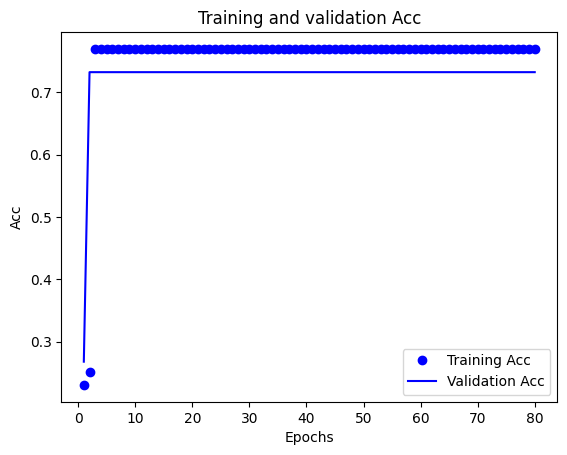

In [91]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [92]:
test_pred_nn = (model.predict(X_test) > 0.5).astype("int32")

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      2316
           1       0.00      0.00      0.00       911

    accuracy                           0.72      3227
   macro avg       0.36      0.50      0.42      3227
weighted avg       0.52      0.72      0.60      3227



c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

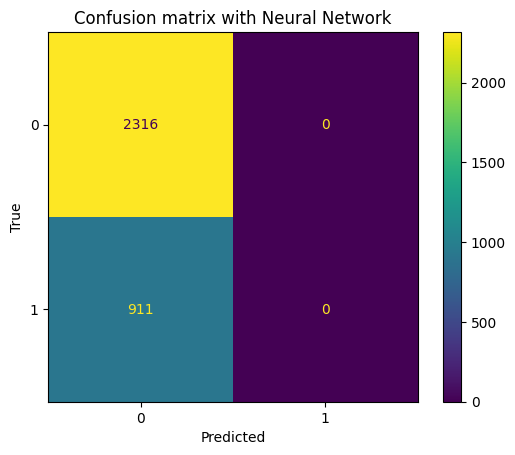

In [93]:
# report_scores
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

print(classification_report(y_test, test_pred_nn))

# confusion matrix
cm_nn = confusion_matrix(y_test, test_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=[0, 1])
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with Neural Network')


plt.show()

In [94]:
import tensorflow as tf
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=X_train.shape[1:]),
  tf.keras.layers.Dense(256, activation='sigmoid'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(256, activation='sigmoid'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adamax',
              loss='mean_squared_error',
              metrics=['accuracy'])

c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [95]:
history = model.fit(X_train, y_train,
                    epochs=80,
                    batch_size=256,
                    validation_split=0.2)

Epoch 1/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7673 - loss: 0.1828 - val_accuracy: 0.7320 - val_loss: 0.2026
Epoch 2/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7687 - loss: 0.1786 - val_accuracy: 0.7320 - val_loss: 0.1963
Epoch 3/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7731 - loss: 0.1752 - val_accuracy: 0.7320 - val_loss: 0.1952
Epoch 4/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7657 - loss: 0.1790 - val_accuracy: 0.7320 - val_loss: 0.1960
Epoch 5/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7681 - loss: 0.1776 - val_accuracy: 0.7320 - val_loss: 0.1950
Epoch 6/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7638 - loss: 0.1793 - val_accuracy: 0.7320 - val_loss: 0.1949
Epoch 7/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7732 - loss: 0.1738 - val_accuracy: 0.7320 - val_loss: 0.1965
Epoch 8/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7658 - loss: 0.1778 - val_accuracy: 0.7320 - val_loss:

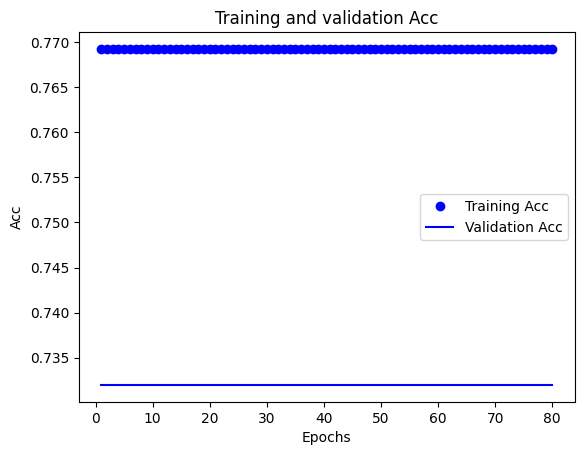

In [96]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [97]:
# scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)



In [98]:
X_train.head(1)

,CRASH_YEAR,CRASH_MONTH,avg_responsibility_score,avg_lighting_severity,fatality_rate,severe_injury_rate,avg_crash_severity_score,injury_severity_score,night_crash_rate,adverse_weather_crash_rate,road_defect_crash_rate,speeding_influence,weekend_crash_rate,avg_age,pct_neo_patented_drivers,pct_senior_drivers,monthly_total_units,combined_weather_road_severity,towed_unit_rate
0,2018,1,0.644,0.511111,0.0,0.01087,0.044372,8.0,0.434783,0.217391,0.065217,0.108696,0.043478,42.202899,0.060241,0.048193,18895,0.432104,0.000212


In [99]:
X_train_scaled[1]

array([-1.4651557 , -1.59565285, -0.24416726, -0.71908175, -0.16708775,
       -0.66247807,  0.64125384, -0.92988732, -0.37143717, -1.00799832,
        0.33433992,  0.11062037, -0.92493084,  1.06864601, -0.55774168,
       -0.57608843,  0.27980897, -0.64955295, -0.27928486])

In [100]:
history = model.fit(X_train_scaled, y_train,
                    epochs=80,
                    batch_size=256,
                    validation_split=0.2)

Epoch 1/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7728 - loss: 0.1737 - val_accuracy: 0.7377 - val_loss: 0.1615
Epoch 2/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8065 - loss: 0.1355 - val_accuracy: 0.7810 - val_loss: 0.1403
Epoch 3/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8373 - loss: 0.1190 - val_accuracy: 0.7970 - val_loss: 0.1358
Epoch 4/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8477 - loss: 0.1088 - val_accuracy: 0.8123 - val_loss: 0.1295
Epoch 5/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8585 - loss: 0.1015 - val_accuracy: 0.8294 - val_loss: 0.1173
Epoch 6/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8649 - loss: 0.0967 - val_accuracy: 0.8294 - val_loss: 0.1186
Epoch 7/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8661 - loss: 0.0966 - val_accuracy: 0.8292 - val_loss: 0.1204
Epoch 8/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8622 - loss: 0.0968 - val_accuracy: 0.8385 - val_loss:

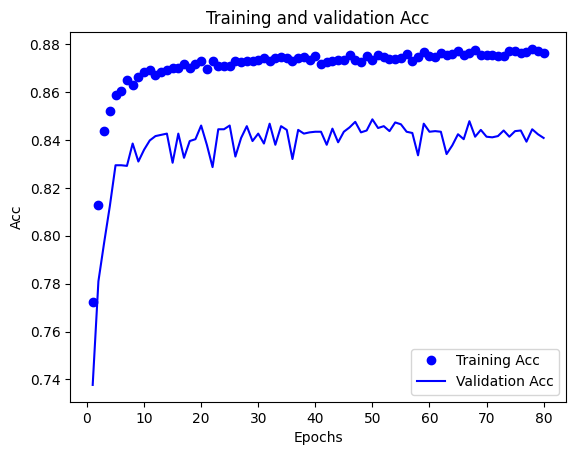

In [101]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [102]:
test_pred_nn = (model.predict(X_test_scaled) > 0.5).astype("int32")

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


              precision    recall  f1-score   support

           0       0.81      0.98      0.89      2316
           1       0.88      0.43      0.58       911

    accuracy                           0.82      3227
   macro avg       0.85      0.70      0.73      3227
weighted avg       0.83      0.82      0.80      3227



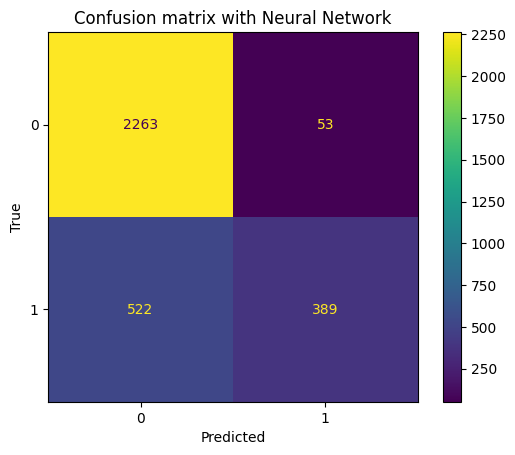

In [103]:
# report_scores
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

print(classification_report(y_test, test_pred_nn))

# confusion matrix
cm_nn = confusion_matrix(y_test, test_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=[0, 1])
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with Neural Network')


plt.show()

---

## grid search for NN

In [104]:
# grid search
hp_nn = {
    'optimizer': ['adam', 'adamax'],
    'neurons1': [32, 64, 128],
    'neurons2': [16, 32, 64],
    'batch_size': [32, 64, 128],
    'epochs': [20, 40, 60]
}

grid_nn = GridSearchCV(estimator=model, param_grid=hp_nn, cv=5, n_jobs=-1, verbose=1)


---